<a href="https://colab.research.google.com/github/ShuichiroTsuda/Kaggle_Liverpool_Ion_Switching/blob/master/simple_lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn import *
from sklearn.metrics import f1_score
import lightgbm as lgb
import seaborn as sns
import time
import datetime

sns.set_style("whitegrid")

from sklearn.model_selection import KFold

#Constants
ROW_PER_BATCH = 500000

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import subprocess
from tqdm import tqdm_notebook as tqdm

def load_api_key():
    with open('/content/drive/My Drive/Colab Notebooks/Kaggle/API_setup/kaggle.json') as f:
        kaggle_api_key = json.load(f)
    
    filename = "/root/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, 'w') as f:
        json.dump(kaggle_api_key, f)

    os.chmod(filename, 600)
    print('API key loaded.')

load_api_key()

def sub_kaggle(fileName, message):
    res = os.system('kaggle competitions submit -c liverpool-ion-switching -f '+ fileName + ' -m "'+ message +'"')

def read_data():
    if not os.path.isfile('train_clean.csv'):
        res = os.system('kaggle datasets download -d cdeotte/data-without-drift')
        print(res)
        res = os.system('unzip data-without-drift.zip')
        print(res)
    train = pd.read_csv('train_clean.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv('test_clean.csv', dtype={'time': np.float32, 'signal': np.float32})

    if not os.path.isfile('sample_submission.csv'):
        res = os.system('kaggle competitions download -c liverpool-ion-switching')
        print(res)
        res = os.system('unzip sample_submission.csv.zip')
        print(res)
    sub  = pd.read_csv('sample_submission.csv', dtype={'time': np.float32})

    print('Data Loaded!')
    
    return train, test, sub

train, test, sub = read_data()

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns):
        if col != 'time':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

API key loaded.
Data Loaded!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Mem. usage decreased to 33.38 Mb (41.7% reduction)



Mem. usage decreased to 11.44 Mb (25.0% reduction)


In [0]:
def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_index'] = df.index  - (df.batch * 50_000)
    df['batch_slices'] = df['batch_index']  // 5_000
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        df['range'+c] = df['max'+c] - df['min'+c]
        df['maxtomin'+c] = df['max'+c] / df['min'+c]
        df['abs_avg'+c] = (df['abs_min'+c] + df['abs_max'+c]) 

    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan

    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal']
        
    return df

train = reduce_mem_usage(features(train))
test = reduce_mem_usage(features(test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Mem. usage decreased to 596.05 Mb (71.0% reduction)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Mem. usage decreased to 236.51 Mb (71.2% reduction)


In [0]:
def f1_score_calc(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def lgb_Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average="macro")
    return ('KaggleMetric', score, True)


def train_model_classification(X, X_test, y, params, model_type='lgb', eval_metric='f1score',
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=50, early_stopping_rounds=200, n_estimators=2000):

    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {
                    'f1score': {'lgb_metric_name': lgb_Metric,}
                   }
    
    result_dict = {}

    # out-of-fold predictions on train data
    oof = np.zeros(len(X) )
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test)))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    '''for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]'''

    if True:        
        X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=7)    
            
        if model_type == 'lgb':
            #model = lgb.LGBMClassifier(**params, n_estimators=n_estimators)
            #model.fit(X_train, y_train, 
            #        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
            #       verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            model = lgb.train(params, lgb.Dataset(X_train, y_train),
                              n_estimators,  lgb.Dataset(X_valid, y_valid),
                              verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds, feval=lgb_Metric)
            
            
            preds = model.predict(X_valid, num_iteration=model.best_iteration) #model.predict(X_valid) 
            y_pred_valid = np.round(np.clip(preds, 0, 10)).astype(int)

            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)

 
        #oof[valid_index] = y_pred_valid
        scores.append(f1_score_calc(y_valid, y_pred_valid ) )

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    #prediction /= folds.n_splits
    
    print('FINAL score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['model'] = model
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [0]:
good_columns = [c for c in train.columns if c not in ['time', 'signal','open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]

X = train[good_columns].copy()
y = train['open_channels']
X_test = test[good_columns].copy()

In [0]:
del train, test

In [0]:
params = {'learning_rate': 0.1, 
          'max_depth': 7, 
          'num_leaves':2**7+1, 
          'metric': 'rmse', 
          'random_state': 7, 
          'n_jobs':-1}

result_dict_lgb = train_model_classification(X=X[0:500000*8-1], 
                                             X_test=X_test, 
                                             y=y[0:500000*8-1], 
                                             params=params, 
                                             model_type='lgb', 
                                             eval_metric='f1score', 
                                             plot_feature_importance=False,
                                             verbose=50, 
                                             early_stopping_rounds=150, 
                                             n_estimators=3000)

Training until validation scores don't improve for 150 rounds.
[50]	valid_0's rmse: 0.139623	valid_0's KaggleMetric: 0.936162
[100]	valid_0's rmse: 0.138304	valid_0's KaggleMetric: 0.937228
[150]	valid_0's rmse: 0.1382	valid_0's KaggleMetric: 0.937234
[200]	valid_0's rmse: 0.138169	valid_0's KaggleMetric: 0.937346
[250]	valid_0's rmse: 0.138089	valid_0's KaggleMetric: 0.937328
Early stopping, best iteration is:
[129]	valid_0's rmse: 0.138233	valid_0's KaggleMetric: 0.937372
FINAL score: 0.9374, std: 0.0000.


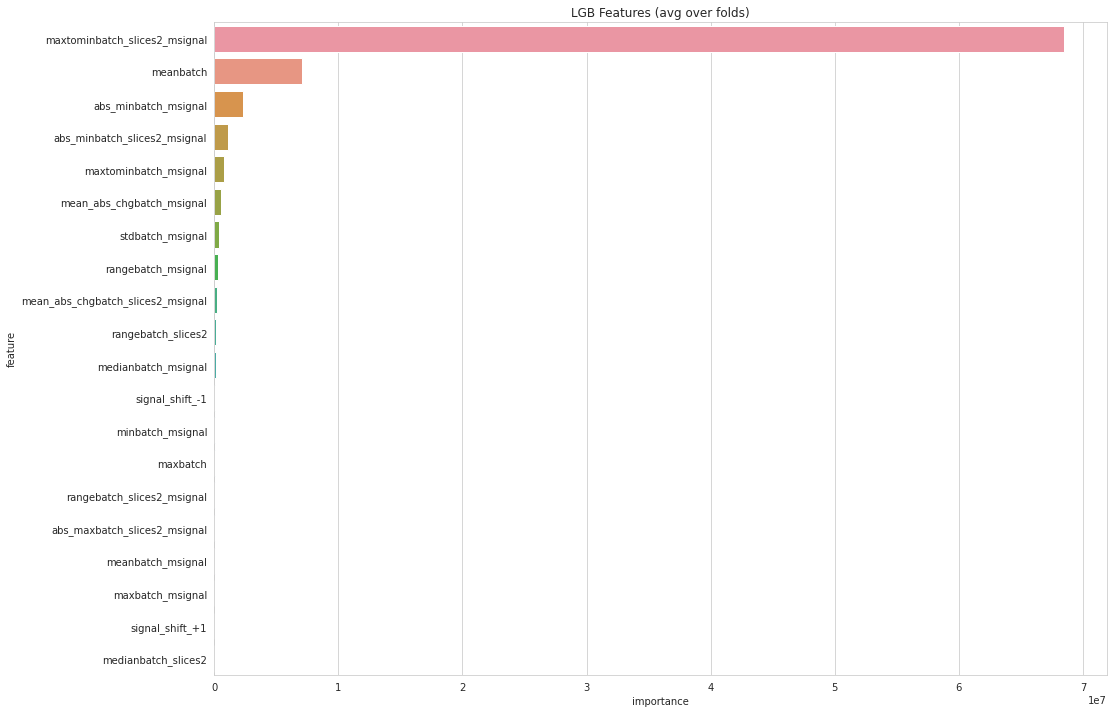

In [13]:
booster = result_dict_lgb['model']

fi = pd.DataFrame()
fi['importance'] = booster.feature_importance(importance_type='gain')
fi['feature'] = booster.feature_name()

best_features = fi.sort_values(by='importance', ascending=False)[:20]


plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features);
plt.title('LGB Features (avg over folds)');

In [14]:
sub['open_channels'] =  np.array(np.round(result_dict_lgb['prediction'],0), np.int) 

sub.to_csv('submission_unshifted_70p.csv', index=False, float_format='%.4f')
sub.head(10)


,time,open_channels
0,500.000092,0
1,500.000214,0
2,500.000305,0
3,500.000397,0
4,500.000488,0
5,500.000610,0
6,500.000702,0
7,500.000793,0
8,500.000885,0
9,500.001007,0


In [15]:
sub.shape

(2000000, 2)

In [0]:
sub_kaggle('submission_unshifted_70p.csv', '3_simple_ideas')